## Plot survival prediction results

In this notebook, we'll compare the results of survival prediction using [elastic net Cox regression](https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.linear_model.CoxnetSurvivalAnalysis.html) for expression and methylation data only.

The files analyzed in this notebook are generated by the `run_survival_prediction.py` script.

Notebook parameters:
* SIG_ALPHA (float): significance cutoff for pairwise comparisons (after FDR correction)

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.survival_utilities as su
import mpmp.utilities.plot_utilities as plu

%load_ext autoreload
%autoreload 2

In [2]:
SIG_ALPHA = 0.05

In [3]:
# set results directory
results_dir = Path(cfg.results_dirs['survival']).resolve()

# load results into a single dataframe
results_df = su.load_survival_results(results_dir)
results_df.rename(columns={'identifier': 'cancer_type',
                           'fold_no': 'fold'}, inplace=True)
results_df.head()

,cindex,data_type,cancer_type,training_data,signal,seed,fold
0,0.50000,train,BRCA,me_450k,shuffled,1,0
1,0.50000,cv,BRCA,me_450k,shuffled,1,0
2,0.50000,test,BRCA,me_450k,shuffled,1,0
3,0.93289,train,BRCA,me_450k,shuffled,1,1
4,0.93289,cv,BRCA,me_450k,shuffled,1,1


### Check model convergence results

In the past we were having issues with model convergence for some cancer types. Let's see how frequently (if at all) this is happening.

In [4]:
count_df = (results_df[results_df.data_type == 'test']
    .groupby(['cancer_type', 'training_data'])
    .count()
)
problem_df = count_df[count_df['cindex'] != 16].copy()
print(len(problem_df), '/', len(count_df))
problem_df

17 / 98


cindex  data_type  signal  seed  fold
cancer_type training_data                                       
ACC         me_27k             12         12      12    12    12
            me_450k            12         12      12    12    12
CHOL        expression         12         12      12    12    12
            me_27k             12         12      12    12    12
            me_450k            12         12      12    12    12
DLBC        expression          4          4       4     4     4
            me_27k              4          4       4     4     4
KICH        expression          8          8       8     8     8
            me_27k              8          8       8     8     8
            me_450k             8          8       8     8     8
PCPG        expression         12         12      12    12    12
            me_27k             12         12      12    12    12
PRAD        me_27k             12         12      12    12    12
READ        me_27k             12         12      12    12    12
            me_450k            12         12      12    12    12
UCS         me_27k             12         12      12    12    12
UVM         expression         12         12      12    12    12

This isn't too bad - only 17/98 cancer type/data type combinations are missing a result for a seed or fold.

We'll just drop those cancer types from our comparisons for now, although we could debug the issues with model convergence sometime in the future.

In [5]:
drop_cancer_types = problem_df.index.get_level_values(0).unique().values
print(drop_cancer_types)

['ACC' 'CHOL' 'DLBC' 'KICH' 'PCPG' 'PRAD' 'READ' 'UCS' 'UVM']


### Plot survival prediction results

We want to compare survival prediction for:
* true labels vs. shuffled labels
* between omics types
    
As a metric, for now we're just using the [censored concordance index](https://scikit-survival.readthedocs.io/en/latest/api/generated/sksurv.metrics.concordance_index_censored.html). Essentially, this compares the actual order of events (i.e. death or tumor progression) in the test dataset vs. the order of events predicted by the model in the test samples. A higher concordance index = better prediction.

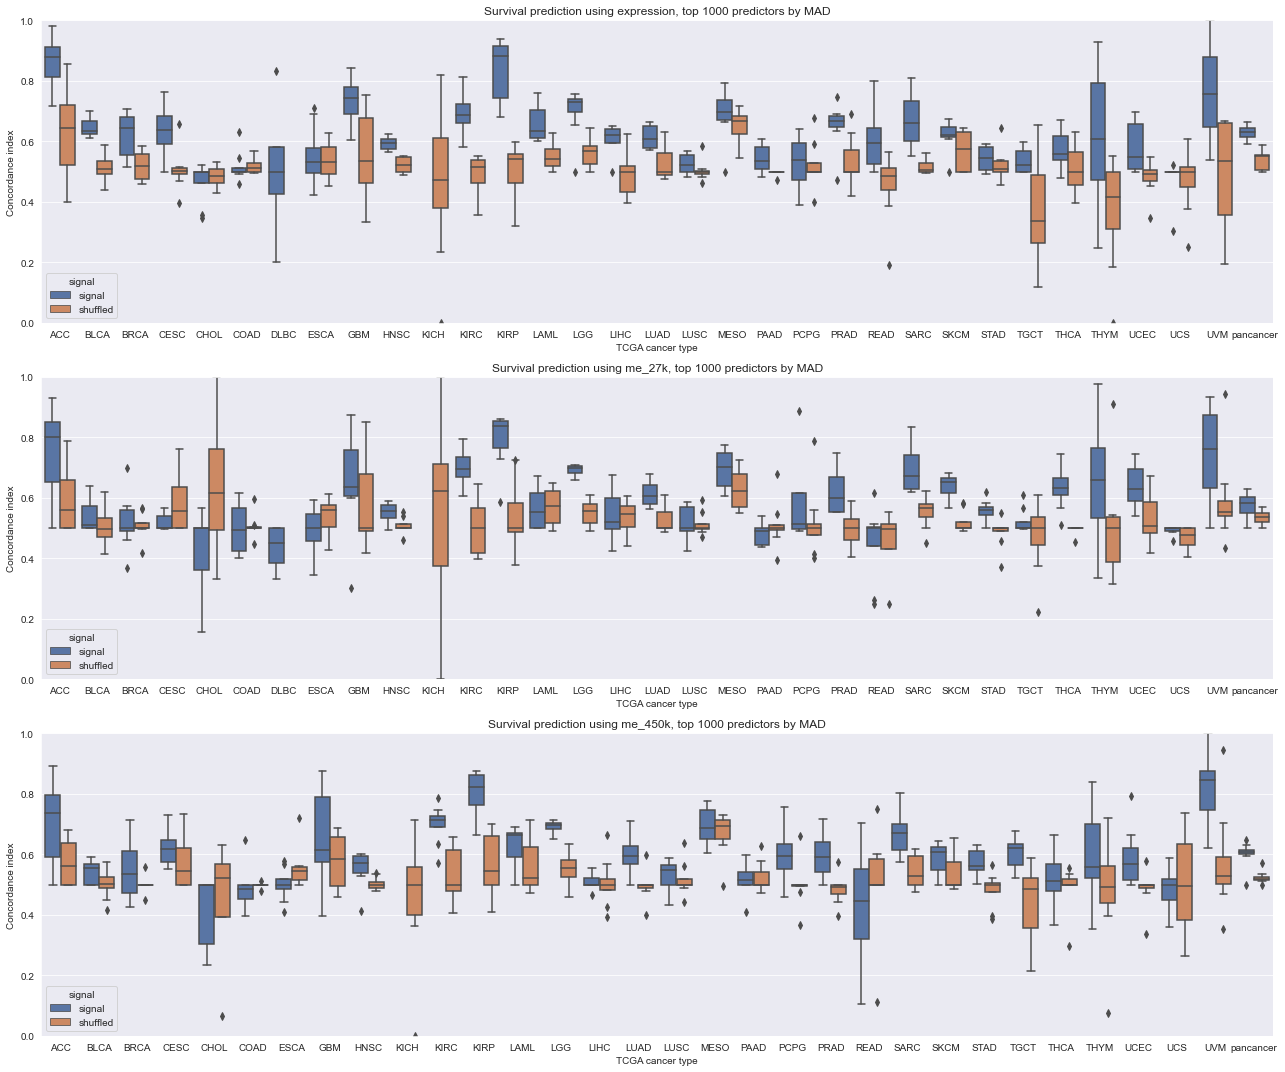

In [6]:
sns.set({'figure.figsize': (18, 15)})
fig, axarr = plt.subplots(3, 1)

for ix, data_type in enumerate(
    results_df.training_data.sort_values().unique()
):
    
    ax = axarr[ix]
    
    filtered_df = results_df[
        (results_df.training_data == data_type) &
        (results_df.data_type == 'test')
    ].copy()

    filtered_df.sort_values(by='cancer_type', inplace=True)

    sns.boxplot(data=filtered_df, x='cancer_type', y='cindex', hue='signal',
                hue_order=['signal', 'shuffled'], ax=ax)
    ax.set_xlabel('TCGA cancer type')
    ax.set_ylabel('Concordance index')
    ax.set_title('Survival prediction using {}, top 1000 predictors by MAD'.format(data_type))
    ax.set_ylim(0.0, 1.0)
    
plt.tight_layout()

In [7]:
results_df['identifier'] = (results_df.cancer_type + '_' +
                            results_df.training_data)
results_df.head()

,cindex,data_type,cancer_type,training_data,signal,seed,fold,identifier
0,0.50000,train,BRCA,me_450k,shuffled,1,0,BRCA_me_450k
1,0.50000,cv,BRCA,me_450k,shuffled,1,0,BRCA_me_450k
2,0.50000,test,BRCA,me_450k,shuffled,1,0,BRCA_me_450k
3,0.93289,train,BRCA,me_450k,shuffled,1,1,BRCA_me_450k
4,0.93289,cv,BRCA,me_450k,shuffled,1,1,BRCA_me_450k


In [8]:
compare_df = au.compare_control_ind(results_df,
                                    identifier='identifier',
                                    metric='cindex',
                                    verbose=True)
compare_df['cancer_type'] = compare_df.identifier.str.split('_', 1, expand=True)[0]
compare_df['training_data'] = compare_df.identifier.str.split('_', 1, expand=True)[1]

print(len(compare_df))
compare_df.head()

shapes unequal for ACC_me_27k, skipping
shapes unequal for ACC_me_450k, skipping
shapes unequal for CHOL_expression, skipping
shapes unequal for CHOL_me_27k, skipping
shapes unequal for CHOL_me_450k, skipping
shapes unequal for DLBC_expression, skipping
shapes unequal for DLBC_me_27k, skipping
shapes unequal for KICH_expression, skipping
shapes unequal for KICH_me_27k, skipping
shapes unequal for KICH_me_450k, skipping
shapes unequal for PCPG_expression, skipping
shapes unequal for PCPG_me_27k, skipping
shapes unequal for PRAD_me_27k, skipping
shapes unequal for READ_me_27k, skipping
shapes unequal for READ_me_450k, skipping


648


shapes unequal for UCS_me_27k, skipping
shapes unequal for UVM_expression, skipping


,identifier,seed,fold,delta_cindex,cancer_type,training_data
0,ACC_expression,1,0,0.06124,ACC,expression
1,ACC_expression,1,1,0.30501,ACC,expression
2,ACC_expression,1,2,0.58276,ACC,expression
3,ACC_expression,1,3,0.18026,ACC,expression
4,ACC_expression,42,0,0.08054,ACC,expression


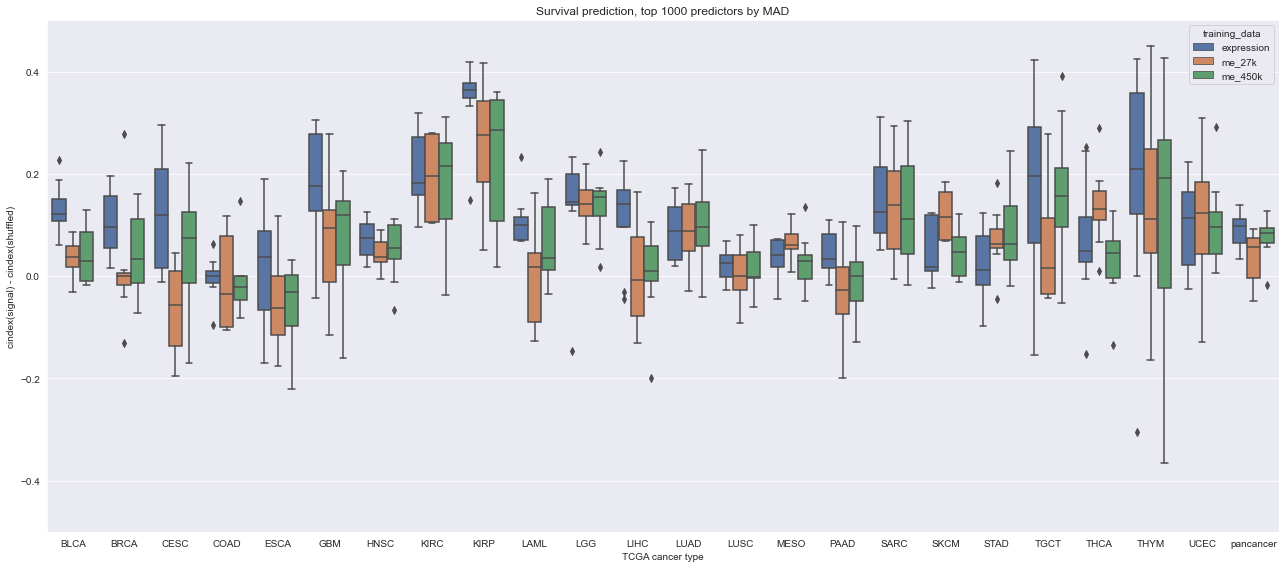

In [9]:
sns.set({'figure.figsize': (18, 8)})
    
compare_df.sort_values(by='cancer_type', inplace=True)

sns.boxplot(data=compare_df[~compare_df.cancer_type.isin(drop_cancer_types)],
            x='cancer_type',
            y='delta_cindex',
            hue='training_data',
            hue_order=['expression', 'me_27k', 'me_450k'])
plt.xlabel('TCGA cancer type')
plt.ylabel('cindex(signal) - cindex(shuffled)')
plt.title('Survival prediction, top 1000 predictors by MAD')
plt.ylim(-0.5, 0.5)
    
plt.tight_layout()

### Heatmap

Heatmap

In [14]:
all_results_df = au.compare_all_data_types(results_df[~results_df.cancer_type.isin(drop_cancer_types)],
                                           SIG_ALPHA,
                                           identifier='cancer_type',
                                           metric='cindex')

all_results_df.rename(columns={'gene': 'cancer_type'}, inplace=True)
all_results_df.sort_values(by='p_value').head(10)

,cancer_type,delta_mean,p_value,corr_pval,reject_null,training_data,nlog10_p
8,KIRP,0.342564,0.000007,0.000167,True,expression,3.776892
7,KIRC,0.204378,0.000125,0.001144,True,expression,2.941659
10,LGG,0.139826,0.000139,0.002394,True,me_27k,2.620908
23,pancancer,0.090165,0.000143,0.001144,True,expression,2.941659
0,BLCA,0.132881,0.000191,0.001144,True,expression,2.941659
17,SKCM,0.119347,0.000199,0.002394,True,me_27k,2.620908
7,KIRC,0.192608,0.000299,0.002396,True,me_27k,2.620604
9,LAML,0.110223,0.000734,0.003522,True,expression,2.453258
8,KIRP,0.253671,0.000754,0.004523,True,me_27k,2.344526
10,LGG,0.137119,0.000912,0.015438,True,me_450k,1.811399


In [16]:
heatmap_df = (all_results_df
    .pivot(index='training_data', columns='cancer_type', values='delta_mean')
    .reindex(['expression', 'me_27k', 'me_450k'])
)
heatmap_df.iloc[:, :5]

cancer_type,BLCA,BRCA,CESC,COAD,ESCA
training_data,,,,,
expression,0.132881,0.102311,0.126767,-0.004247,0.010929
me_27k,0.036625,0.013847,-0.066174,-0.009584,-0.049943
me_450k,0.040253,0.046963,0.048925,-0.009141,-0.056725


Text(0.5, 1.0, 'Performance by cancer type for survival prediction, expression vs. methylation')

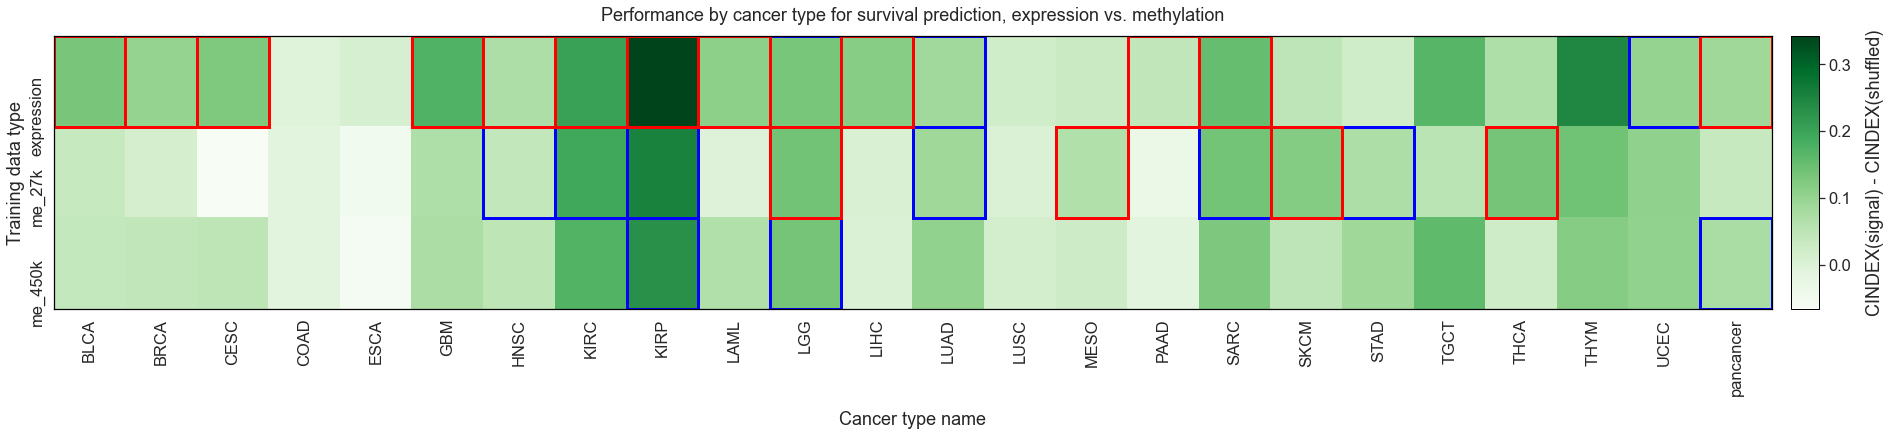

In [20]:
sns.set({'figure.figsize': (28, 6)})
sns.set_context('notebook', font_scale=1.5)

ax = plu.plot_heatmap(heatmap_df,
                      all_results_df.reset_index(drop=True),
                      # different_from_best=True,
                      different_from_best=False,
                      raw_results_df=results_df,
                      metric='cindex',
                      id_name='cancer_type')

plt.title('Performance by cancer type for survival prediction, expression vs. methylation', pad=15)

# if SAVE_FIGS:
#     plt.savefig(images_dir / 'methylation_heatmap.svg', bbox_inches='tight')
#     plt.savefig(images_dir / 'methylation_heatmap.png',
#                 dpi=300, bbox_inches='tight')